Подгружаем все необходимые библиотеки

In [1]:
import pandas as pd 
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## Загрузка данных

Грузим данные акций sp500 для дальнейшей работы за период 2020 года для прогнозирования и 2021 года для теста, проверяем их корректность

In [2]:
sp500_data = pd.DataFrame(web.DataReader(['sp500'], data_source = "fred", start=datetime.datetime(2020, 1, 1), 
                            end =datetime.datetime(2020, 12, 31)))
test_data = pd.DataFrame(web.DataReader(['sp500'], data_source = "fred", start=datetime.datetime(2021, 1, 1), 
                            end =datetime.datetime(2021, 12, 31)))

In [3]:
sp500_data

,sp500
DATE,
2020-01-01,NaN
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
...,...
2020-12-25,NaN
2020-12-28,3735.36
2020-12-29,3727.04


In [4]:
iplot([
    go.Scatter(x=sp500_data.index , y=sp500_data.sp500, name='sp500')
]);

plt.show()

Видим пропуски в данных, их можно заполнить с помощью backfill – bfill : according to the last observed value

In [5]:
sp500_data = sp500_data.bfill()
test_data = test_data.bfill()

In [6]:
iplot([
    go.Scatter(x=sp500_data.index , y=sp500_data.sp500, name='sp500')
]);

plt.show()

Сразу сохраним все данные для дальнейшего использования

In [7]:
sp500_data.to_csv('sp500_data')
test_data.to_csv('test_data')

In [8]:
sp500_data = pd.read_csv('sp500_data')
test_data = pd.read_csv('test_data')

Попробуем посчитать скользящее среднее

In [9]:
rolling_mean2 = sp500_data.sp500.rolling(window=2).mean()
rolling_mean5 = sp500_data.sp500.rolling(window=5).mean()
rolling_mean8 = sp500_data.sp500.rolling(window=8).mean()

In [10]:
iplot([
    go.Scatter(x=sp500_data.index , y=sp500_data.sp500, name='sp500'),
    go.Scatter(x=sp500_data.index , y=rolling_mean2, name='rm2'),
    go.Scatter(x=sp500_data.index , y=rolling_mean5, name='rm5'),
    go.Scatter(x=sp500_data.index , y=rolling_mean8, name='rm8')
    
]);

plt.show()

На графике видно, что слишком маленькое окно переподгоняется к данным, а не к тенденции, а большое имеет некоторое смещение относительно реальных значений и общей тенденции

Попробуем для разных размеров окон подсчитать такие метрики качества прогноза, как mae и mape. Для этого используем "кросс валидацию" для временного ряда - TimeSeriesSplit

In [11]:
tscv = TimeSeriesSplit()

In [12]:
mae_scores = [[],[],[],[],[],[],[],[],[],[],]
mape_scores = [[],[],[],[],[],[],[],[],[],[],]
for train_index, test_index in tscv.split(sp500_data):
    X_train, X_test = sp500_data.sp500.values[train_index], sp500_data.sp500.values[test_index]
    for window in range(1,10):
        predictions = list()
        for t in range(len(X_test)):
            length = len(X_train)
            yhat = np.mean([X_train[i] for i in range(length-window,length)])
            predictions.append(yhat)
            X_train = np.append(X_train,X_test[t])
        error_mae = mean_absolute_error(X_test, predictions)
        error_mape = mean_absolute_percentage_error(X_test, predictions)
        
        mae_scores[window].append(error_mae)
        mape_scores[window].append(error_mape)

In [13]:
for window, scores in enumerate(mae_scores):
    if window == 0:
        continue
    print("Window = ", window, ", mae = ", np.mean(scores), ", mape = ", 
          float('{:.3f}'.format(np.mean(mape_scores[window]))), '%')

Window =  1 , mae =  40.77372093023255 , mape =  0.014 %
Window =  2 , mae =  46.42106976744185 , mape =  0.015 %
Window =  3 , mae =  52.01931782945735 , mape =  0.017 %
Window =  4 , mae =  57.803651162790686 , mape =  0.019 %
Window =  5 , mae =  62.853990697674384 , mape =  0.021 %
Window =  6 , mae =  67.20640310077518 , mape =  0.022 %
Window =  7 , mae =  70.09994684385381 , mape =  0.023 %
Window =  8 , mae =  73.23298837209299 , mape =  0.024 %
Window =  9 , mae =  76.12607751937983 , mape =  0.025 %


Видим, что ошибка лишь увеличивается при увеличении окна, но также мы уже видели переподгонку меньшего окна к данным, поэтому попробуем изобразить разные окна на графиках

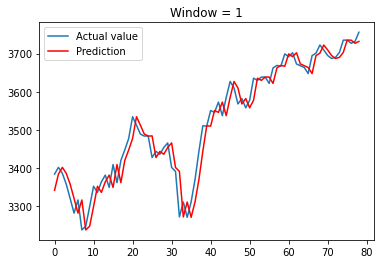

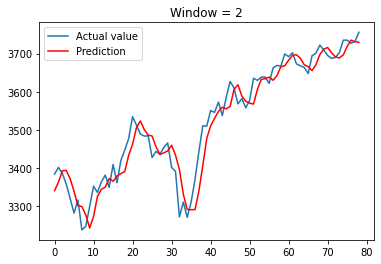

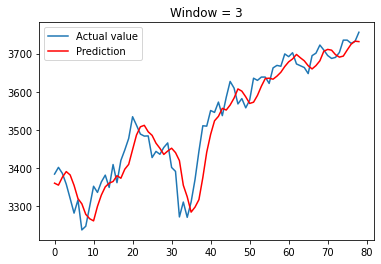

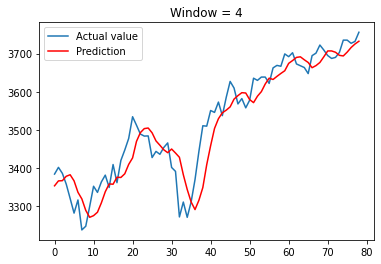

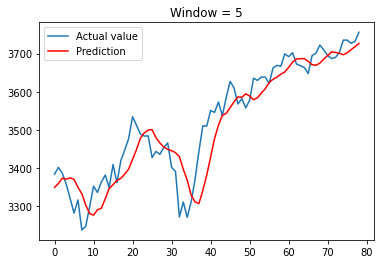

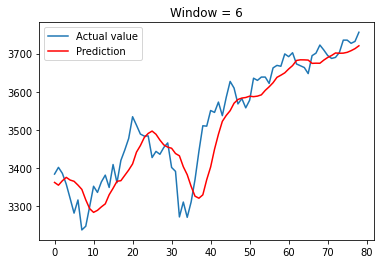

In [14]:
window = 3
data_rate = 0.7
for window in range(1,7):
    X_train, X_test = sp500_data.sp500.values[:int(len(sp500_data)*data_rate)], \
    sp500_data.sp500.values[int(len(sp500_data)*data_rate):]
#print(X_test)
    predictions = list()
    for t in range(len(X_test)):
     #print(X_test[t])
        length = len(X_train)
        yhat = np.mean([X_train[i] for i in range(length-window,length)])
        #print([X_train[i] for i in range(length-window,length)])
        predictions.append(yhat)
        X_train = np.append(X_train,X_test[t])
    pyplot.plot(X_test)
    pyplot.plot(predictions, color='red')
    pyplot.title("Window = "+ str(window))
    pyplot.legend(['Actual value', 'Prediction'])
    pyplot.show()

Но на графиках видно, что малое значение окна переподгоняется к данным и по сути мало полезно, нам нужна сама тенденция роста или спада

Ориентируясь на краткосрочные тенденции для "быстрых" продаж и покупок, возьмем размер окна = 5

Для предсказания долгосрочной тенденции лучше подходит большое значение окна, например, 40 или 50. Посмотрим на них визуально и оценим их ошибку предсказания

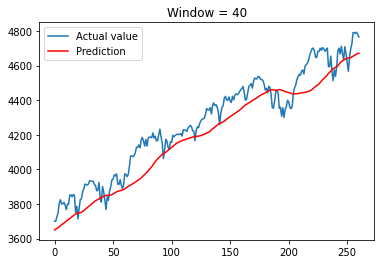

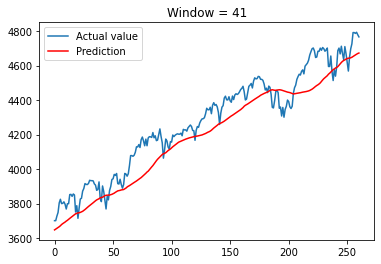

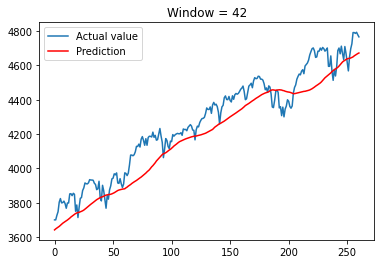

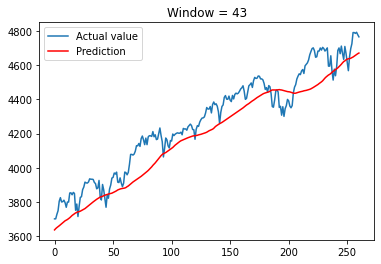

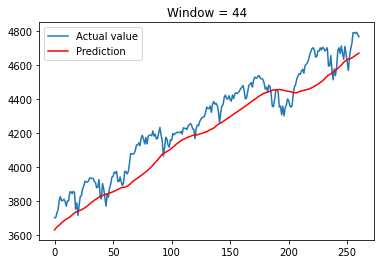

In [15]:
window = 50
for window in range(40,45):
    X_train, X_test = sp500_data.sp500, \
    test_data.sp500
#print(X_test)
    predictions = list()
    for t in range(len(X_test)):
     #print(X_test[t])
        length = len(X_train)
        yhat = np.mean([X_train[i] for i in range(length-window,length)])
        #print([X_train[i] for i in range(length-window,length)])
        predictions.append(yhat)
        X_train = np.append(X_train,X_test[t])
    pyplot.plot(X_test)
    pyplot.plot(predictions, color='red')
    pyplot.title("Window = "+ str(window))
    pyplot.legend(['Actual value', 'Prediction'])
    pyplot.show()

In [16]:
mae_scores = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],]
mape_scores = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],]
window_start = 45
window_end = 65

for train_index, test_index in tscv.split(sp500_data):
    X_train, X_test = sp500_data.sp500.values[train_index], sp500_data.sp500.values[test_index]
    id_wind=0
    for window in range(window_start,window_end):
        predictions = list()
        for t in range(len(X_test)):
            length = len(X_train)
            yhat = np.mean([X_train[i] for i in range(length-window,length)])
            predictions.append(yhat)
            X_train = np.append(X_train,X_test[t])
        error_mae = mean_absolute_error(X_test, predictions)
        error_mape = mean_absolute_percentage_error(X_test, predictions)
        
        mae_scores[id_wind].append(error_mae)
        mape_scores[id_wind].append(error_mape)
        id_wind+=1

In [17]:
for ind in range(0,window_end-window_start):
    print("Window = ", window_start, ", mae = ", np.mean(mae_scores[ind]), ", mape = ", 
          float('{:.3f}'.format(np.mean(mape_scores[ind]))), '%')
    window_start+=1

Window =  45 , mae =  175.85048578811364 , mape =  0.059 %
Window =  46 , mae =  88.5444994944388 , mape =  0.029 %
Window =  47 , mae =  88.4193330034636 , mape =  0.029 %
Window =  48 , mae =  87.53309302325583 , mape =  0.029 %
Window =  49 , mae =  86.85519886093974 , mape =  0.029 %
Window =  50 , mae =  86.31141767441864 , mape =  0.028 %
Window =  51 , mae =  86.03530323757414 , mape =  0.028 %
Window =  52 , mae =  85.9794436493739 , mape =  0.028 %
Window =  53 , mae =  86.14382799473456 , mape =  0.028 %
Window =  54 , mae =  86.56512144702847 , mape =  0.029 %
Window =  55 , mae =  87.1854156448203 , mape =  0.029 %
Window =  56 , mae =  87.93011295681062 , mape =  0.029 %
Window =  57 , mae =  88.74183761729905 , mape =  0.029 %
Window =  58 , mae =  89.69120769847635 , mape =  0.03 %
Window =  59 , mae =  90.60845092629093 , mape =  0.03 %
Window =  60 , mae =  91.57478759689926 , mape =  0.03 %
Window =  61 , mae =  92.56334578726651 , mape =  0.031 %
Window =  62 , mae =

Видно, что для размера окна в таком диапазоне оптимально значение 52, оно дает наименьшую ошибку